# Cuaderno 02: Entrenamiento de la Vía Auditiva (Fonema -> Clasificación)

### Objetivo 🎯
El objetivo de este cuaderno es entrenar y evaluar un modelo de **vía auditiva**. Este modelo aprenderá a **discriminar** entre un conjunto fijo de fonemas a partir de las secuencias de embeddings que generamos en el cuaderno anterior con `wav2vec2`.

Realizaremos este proceso de forma comparativa para español e inglés en una sola ejecución para analizar las diferencias de rendimiento.

### Flujo de Trabajo ⚙️
1.  **Configuración**: Definiremos las rutas, los hiperparámetros del entrenamiento y las librerías necesarias.
2.  **Preparación de Datos**: Crearemos una clase `Dataset` de PyTorch y una función `collate_fn` para cargar los embeddings `.npy` y manejar las secuencias de longitud variable mediante **padding**.
3.  **Definición del Modelo**: Construiremos una **Red Neuronal Convolucional 1D (CNN 1D)**, una arquitectura ideal para encontrar patrones en datos secuenciales.
4.  **Entrenamiento y Evaluación**: Iteraremos sobre cada idioma, entrenando un modelo para cada uno sobre el conjunto completo de fonemas. El objetivo es que aprenda a distinguirlos entre sí.
5.  **Análisis Comparativo**: Generaremos visualizaciones lado a lado (curvas de aprendizaje, matrices de confusión, heatmaps de logits y gráficos t-SNE) para comparar directamente el rendimiento y las representaciones aprendidas entre español e inglés.

## Paso 1: Configuración e Instalación

Comenzamos instalando las librerías necesarias e importando todos los módulos que utilizaremos a lo largo del cuaderno. También definimos los parámetros globales y las rutas a los datos generados en el paso anterior.

In [1]:
%pip install transformers torch torchaudio librosa scikit-learn seaborn pandas matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Librerías estándar y de manejo de datos
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import warnings # <--- AÑADIR ESTA LÍNEA

# PyTorch y utilidades de machine learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.manifold import TSNE

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# --- Parámetros Globales del Experimento ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "auditory_cnn1d_comparative"
EPOCHS = 200 
BATCH_SIZE = 32
LEARNING_RATE = 0.001
RANDOM_SEED = 42

# --- Rutas del Proyecto ---
project_root = Path.cwd().parent
embedding_dir_root = project_root / "data/02_processed/wav2vec2_embeddings"
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"

# Crear directorios de salida si no existen
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Diccionario para almacenar todos los resultados
results_auditory = {}

## Paso 2: Preparación de Datos

Definimos la clase `PhonemeEmbeddingDataset` que cargará los archivos de embeddings `.npy` bajo demanda. También creamos la función `collate_fn`, que es esencial para el procesamiento en lotes (batches). Como nuestros embeddings de audio son secuencias de longitud variable, esta función añade "padding" (ceros) a las secuencias más cortas de cada lote para que todas tengan la misma dimensión.

In [4]:
class PhonemeEmbeddingDataset(Dataset):
    """Dataset para cargar secuencias de embeddings y sus etiquetas."""
    def __init__(self, embedding_dir):
        self.embedding_paths = sorted(list(embedding_dir.glob("*.npy")))
        self.labels = [p.stem for p in self.embedding_paths]
        self.label_to_int = {label: i for i, label in enumerate(self.labels)}

    def __len__(self):
        return len(self.embedding_paths)

    def __getitem__(self, idx):
        path = self.embedding_paths[idx]
        label_str = path.stem
        label_int = self.label_to_int[label_str]
        embedding = torch.tensor(np.load(path), dtype=torch.float32)
        return embedding, torch.tensor(label_int, dtype=torch.long)

def collate_fn(batch):
    """Aplica padding a las secuencias de embeddings de un lote."""
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    labels = torch.stack(labels)
    
    return padded_embeddings, labels

## Paso 3: Definición del Modelo (CNN 1D)

Para la tarea de clasificar fonemas, una **Red Neuronal Convolucional 1D (CNN 1D)** es una arquitectura ideal.

### Justificación Teórica 🧠
Los embeddings de `wav2vec2` son **secuencias temporales**. Una CNN 1D es excelente para estos datos porque:

1.  **Detecta Patrones Locales**: Sus filtros se deslizan a lo largo del tiempo, aprendiendo a identificar patrones fonéticos cortos y característicos (ej. la explosión de una `/p/` o la fricción de una `/s/`).
2.  **Agrega Información Temporal**: Mediante capas de pooling (en nuestro caso, `AdaptiveMaxPool1d`), el modelo puede resumir las características detectadas a lo largo de toda la secuencia en un único vector de tamaño fijo, sin importar la duración original del fonema. Esto lo hace robusto frente a las variaciones de longitud.
3.  **Jerarquía de Características**: Al apilar capas, el modelo combina patrones simples en representaciones más complejas y abstractas, lo que le permite una clasificación más precisa.

In [5]:
class PhonemeCNN(nn.Module):
    """CNN 1D para clasificar secuencias de embeddings de fonemas."""
    def __init__(self, input_size, num_classes, dropout=0.5):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveMaxPool1d(1) # Global Max Pooling
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # La entrada x tiene forma (batch, seq_len, features)
        # Conv1D espera (batch, features, seq_len), así que la permutamos
        x = x.permute(0, 2, 1)
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Aplanamos el tensor
        x = self.dropout(x)
        x = self.fc(x) # Logits de salida
        return x

## Paso 4: Bucle de Entrenamiento y Evaluación

Este es el bucle principal. Para cada idioma:
1.  Se instancia el `Dataset` y el `DataLoader`. A diferencia de un problema de clasificación tradicional, aquí tenemos **un solo ejemplo por clase**. Por tanto, entrenamos sobre el conjunto completo para que el modelo aprenda a discriminar entre todos los fonemas disponibles.
2.  Se entrena el modelo `PhonemeCNN`.
3.  Se evalúa el rendimiento final sobre ese mismo conjunto de datos para medir la precisión de la discriminación.
4.  Todos los artefactos se almacenan en el diccionario `results_auditory` para su posterior visualización.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(RANDOM_SEED)

for lang in LANGUAGES:
    print(f"\n{'='*20} PROCESANDO IDIOMA: {lang.upper()} {'='*20}")
    
    # --- Carga de datos ---
    embedding_dir = embedding_dir_root / lang
    full_dataset = PhonemeEmbeddingDataset(embedding_dir)
    data_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

    print(f"Dataset para '{lang}': {len(full_dataset)} ejemplos para entrenamiento y evaluación.")
    
    # --- Inicialización del modelo ---
    input_size = full_dataset[0][0].shape[1]
    num_classes = len(full_dataset.labels)
    model = PhonemeCNN(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # --- Bucle de entrenamiento ---
    history = {'train_loss': [], 'train_acc': []}
    
    for epoch in tqdm(range(EPOCHS), desc=f'Entrenando {lang.upper()}'):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for embeddings, labels in data_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        history['train_loss'].append(train_loss / len(data_loader))
        history['train_acc'].append(100 * train_correct / train_total)
    
    print(f"Entrenamiento para '{lang.upper()}' finalizado. Accuracy final: {history['train_acc'][-1]:.2f}%")

    # --- Evaluación final y almacenamiento de resultados ---
    model.eval()
    y_true, y_pred, all_logits = [], [], []
    with torch.no_grad():
        # Usamos el mismo loader, pero sin shuffle sería ideal para el orden de los logits
        eval_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
        for embeddings, labels in eval_loader:
            outputs = model(embeddings.to(device))
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            all_logits.append(outputs.cpu().numpy())

    results_auditory[lang] = {
        'model': model, 'history': history, 'dataset': full_dataset,
        'y_true': y_true, 'y_pred': y_pred, 'logits': np.vstack(all_logits),
        'labels': full_dataset.labels
    }


==================== PROCESANDO IDIOMA: ES ====================
Dataset para 'es': 25 ejemplos para entrenamiento y evaluación.


Entrenando ES:   0%|          | 0/200 [00:00<?, ?it/s]

Entrenamiento para 'ES' finalizado. Accuracy final: 88.00%

==================== PROCESANDO IDIOMA: EN ====================
Dataset para 'en': 25 ejemplos para entrenamiento y evaluación.


Entrenando EN:   0%|          | 0/200 [00:00<?, ?it/s]

Entrenamiento para 'EN' finalizado. Accuracy final: 84.00%


## Paso 5: Visualizaciones Comparativas

Con los modelos entrenados y los resultados guardados, ahora podemos generar una serie de gráficos para comparar visualmente el rendimiento y las representaciones internas de los modelos para español e inglés.

### 5.1 Curvas de Aprendizaje Comparativas

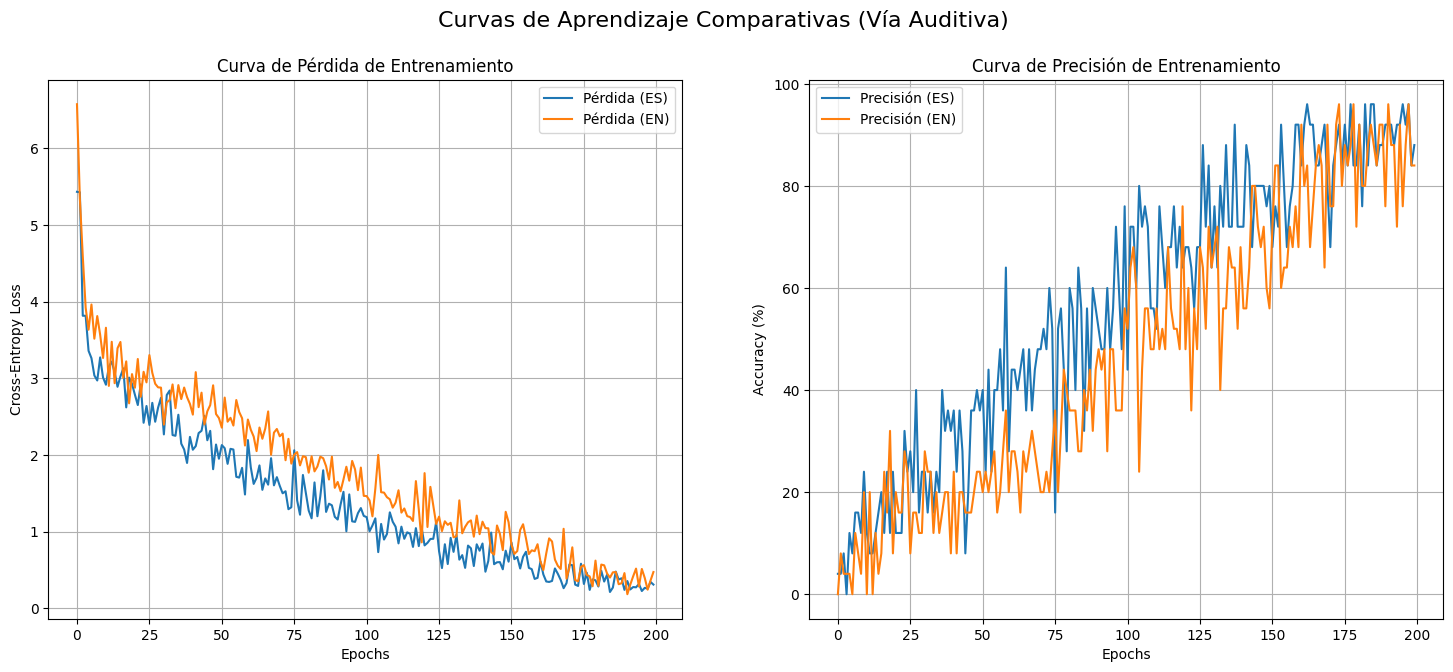

In [7]:
# --- 5.1 Curvas de Aprendizaje Comparativas ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico de Pérdida
for lang in LANGUAGES:
    ax1.plot(results_auditory[lang]['history']['train_loss'], label=f'Pérdida ({lang.upper()})')
ax1.set_title('Curva de Pérdida de Entrenamiento')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Cross-Entropy Loss'); ax1.legend(); ax1.grid(True)

# Gráfico de Precisión
for lang in LANGUAGES:
    ax2.plot(results_auditory[lang]['history']['train_acc'], label=f'Precisión ({lang.upper()})')
ax2.set_title('Curva de Precisión de Entrenamiento')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy (%)'); ax2.legend(); ax2.grid(True)

fig.suptitle('Curvas de Aprendizaje Comparativas (Vía Auditiva)', fontsize=16)
plt.savefig(figure_dir / f"comparative_{MODEL_ARCHITECTURE}_learning_curves.png")
plt.show()

### 5.2 Matrices de Confusión (Lado a Lado)

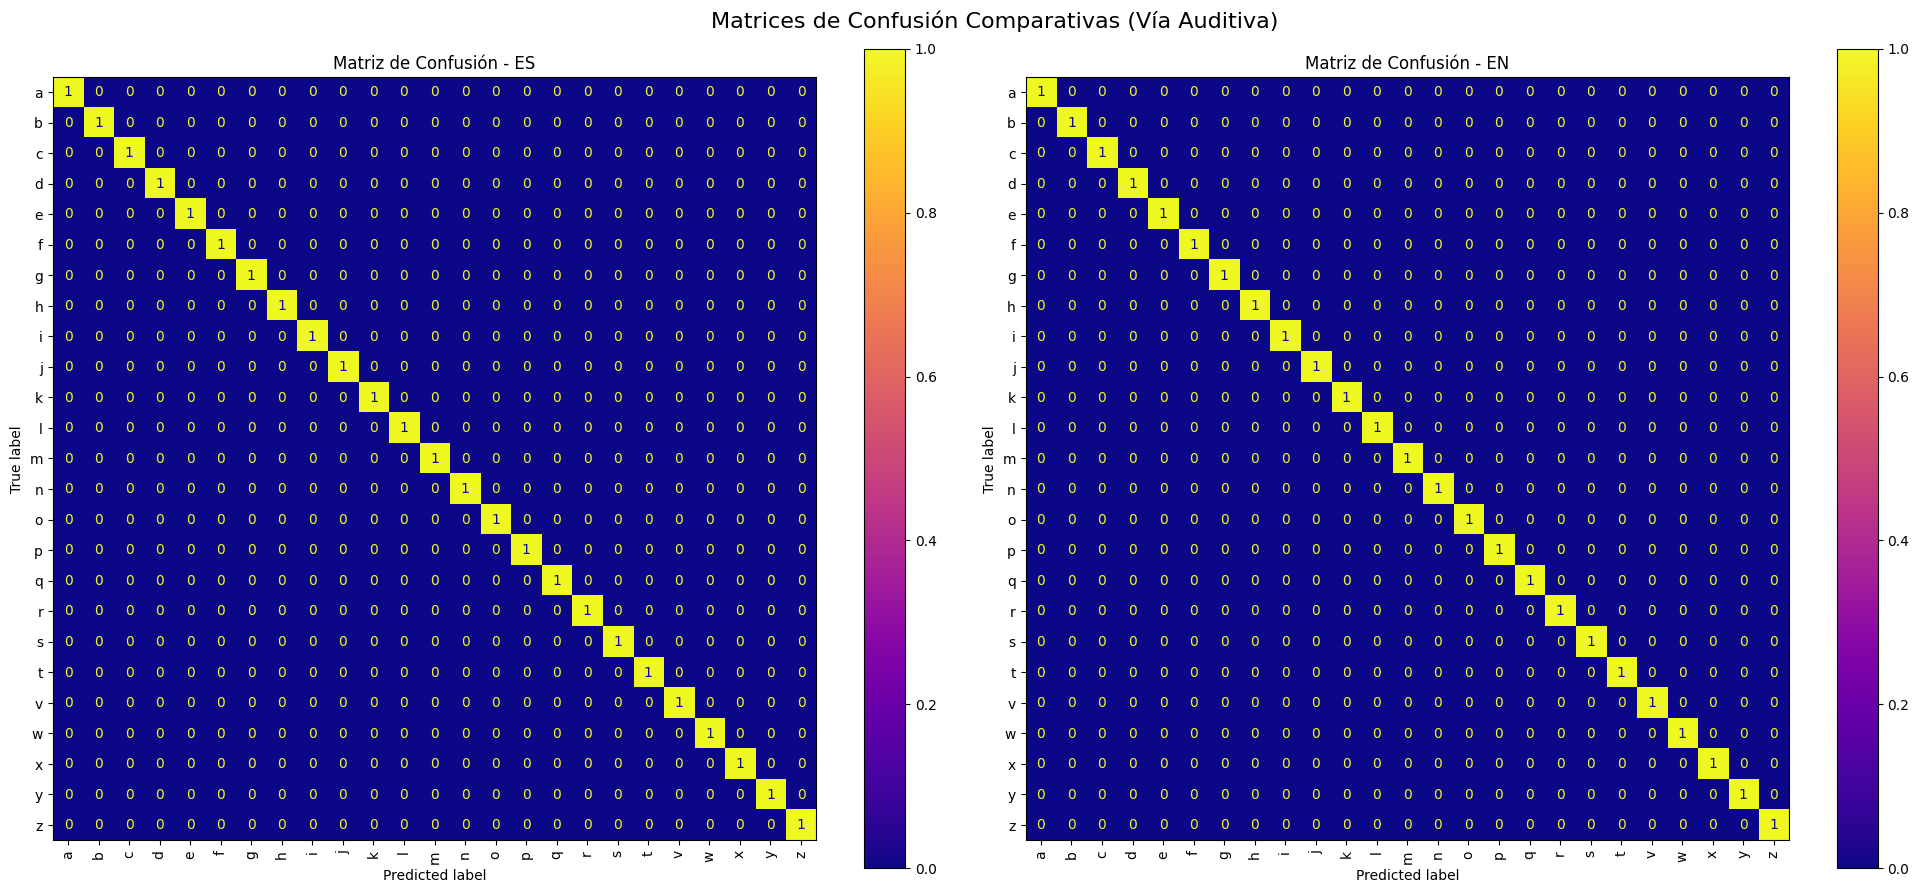

In [8]:
# --- 5.2 Matrices de Confusión (Lado a Lado) ---

# Suprimimos el UserWarning de scikit-learn para esta celda
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)

    fig, axes = plt.subplots(1, len(LANGUAGES), figsize=(20, 9))
    if len(LANGUAGES) == 1: axes = [axes] # Asegurar que sea iterable

    for i, lang in enumerate(LANGUAGES):
        ax = axes[i]
        res = results_auditory[lang]
        cm = confusion_matrix(res['y_true'], res['y_pred'], labels=range(len(res['labels'])))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=res['labels'])
        disp.plot(ax=ax, xticks_rotation='vertical', cmap='plasma')
        ax.set_title(f'Matriz de Confusión - {lang.upper()}')

    fig.suptitle('Matrices de Confusión Comparativas (Vía Auditiva)', fontsize=16)
    plt.tight_layout()
    plt.savefig(figure_dir / f"comparative_{MODEL_ARCHITECTURE}_confusion_matrix.png")
    plt.show()

### 5.3 Análisis de Embeddings t-SNE (Fusionado)

Calculando proyección t-SNE para ambos idiomas...


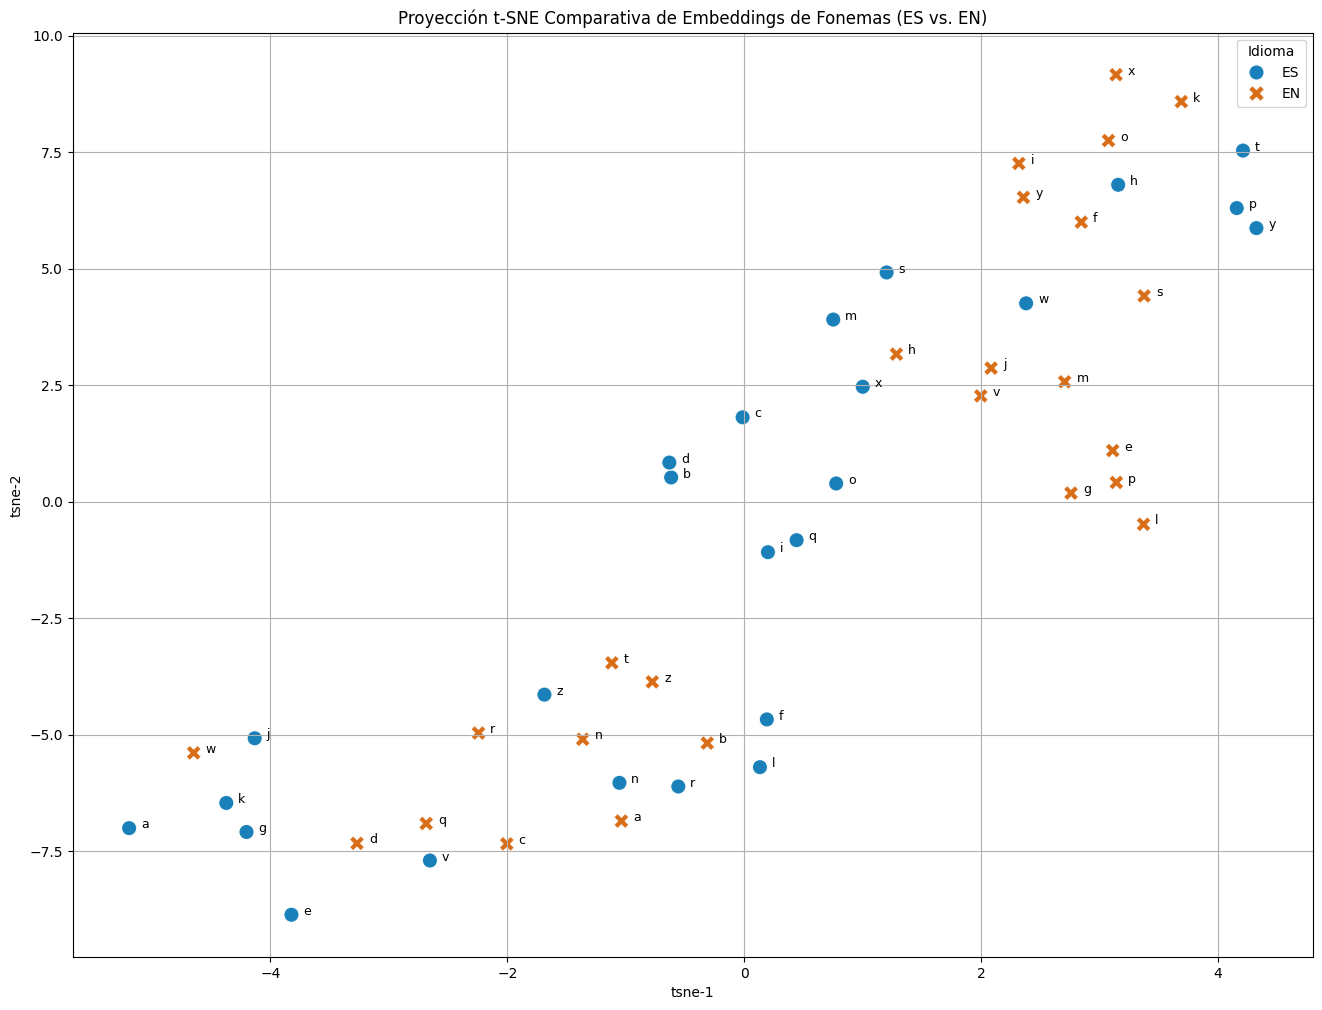

In [9]:
# --- 5.3 Análisis de Embeddings t-SNE (Fusionado) ---
all_embeddings_avg, all_labels, all_langs_tsne = [], [], []

for lang in LANGUAGES:
    dataset = results_auditory[lang]['dataset']
    lang_embeddings_avg = [dataset[i][0].mean(dim=0).numpy() for i in range(len(dataset))]
    all_embeddings_avg.extend(lang_embeddings_avg)
    all_labels.extend(dataset.labels)
    all_langs_tsne.extend([lang.upper()] * len(dataset.labels))

print("Calculando proyección t-SNE para ambos idiomas...")
tsne = TSNE(n_components=2, perplexity=15, random_state=RANDOM_SEED, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(np.array(all_embeddings_avg))

tsne_df = pd.DataFrame({
    'tsne-1': embeddings_2d[:, 0], 'tsne-2': embeddings_2d[:, 1],
    'phoneme': all_labels, 'language': all_langs_tsne
})

# --- Graficar con colores y marcadores personalizados ---
plt.figure(figsize=(16, 12))
palette = {'ES': '#0072B2', 'EN': '#D55E00'} # Azul para ES, Naranja para EN
markers = {'ES': 'o', 'EN': 'X'} # Círculo para ES, X para EN

sns.scatterplot(
    x="tsne-1", y="tsne-2", hue="language", style="language",
    palette=palette, markers=markers, data=tsne_df, s=120, alpha=0.9
)

for i, row in tsne_df.iterrows():
    plt.text(row['tsne-1']+0.1, row['tsne-2'], row['phoneme'], fontsize=9)

plt.title('Proyección t-SNE Comparativa de Embeddings de Fonemas (ES vs. EN)')
plt.grid(True)
plt.legend(title='Idioma')
plt.savefig(figure_dir / f"comparative_{MODEL_ARCHITECTURE}_tsne_plot.png")
plt.show()

### 5.4 Heatmaps de Logits Comparativos

Mientras que la matriz de confusión nos muestra las decisiones finales (aciertos y errores), un heatmap de los **logits** nos permite ver la "fuerza de la evidencia" que el modelo considera para cada clase.

-   Una **diagonal brillante** indica que el modelo asigna una puntuación muy alta al fonema correcto.
-   **Puntos brillantes fuera de la diagonal** revelan qué fonemas son fonéticamente similares para el modelo, incluso si no fueron la predicción final.

Aquí podemos esperar ver una diagonal más "fuerte" y "limpia" para el español, y más "confusión" (puntuaciones altas fuera de la diagonal) para el inglés, lo que apoyaría la hipótesis de la transparencia grafema-fonema.

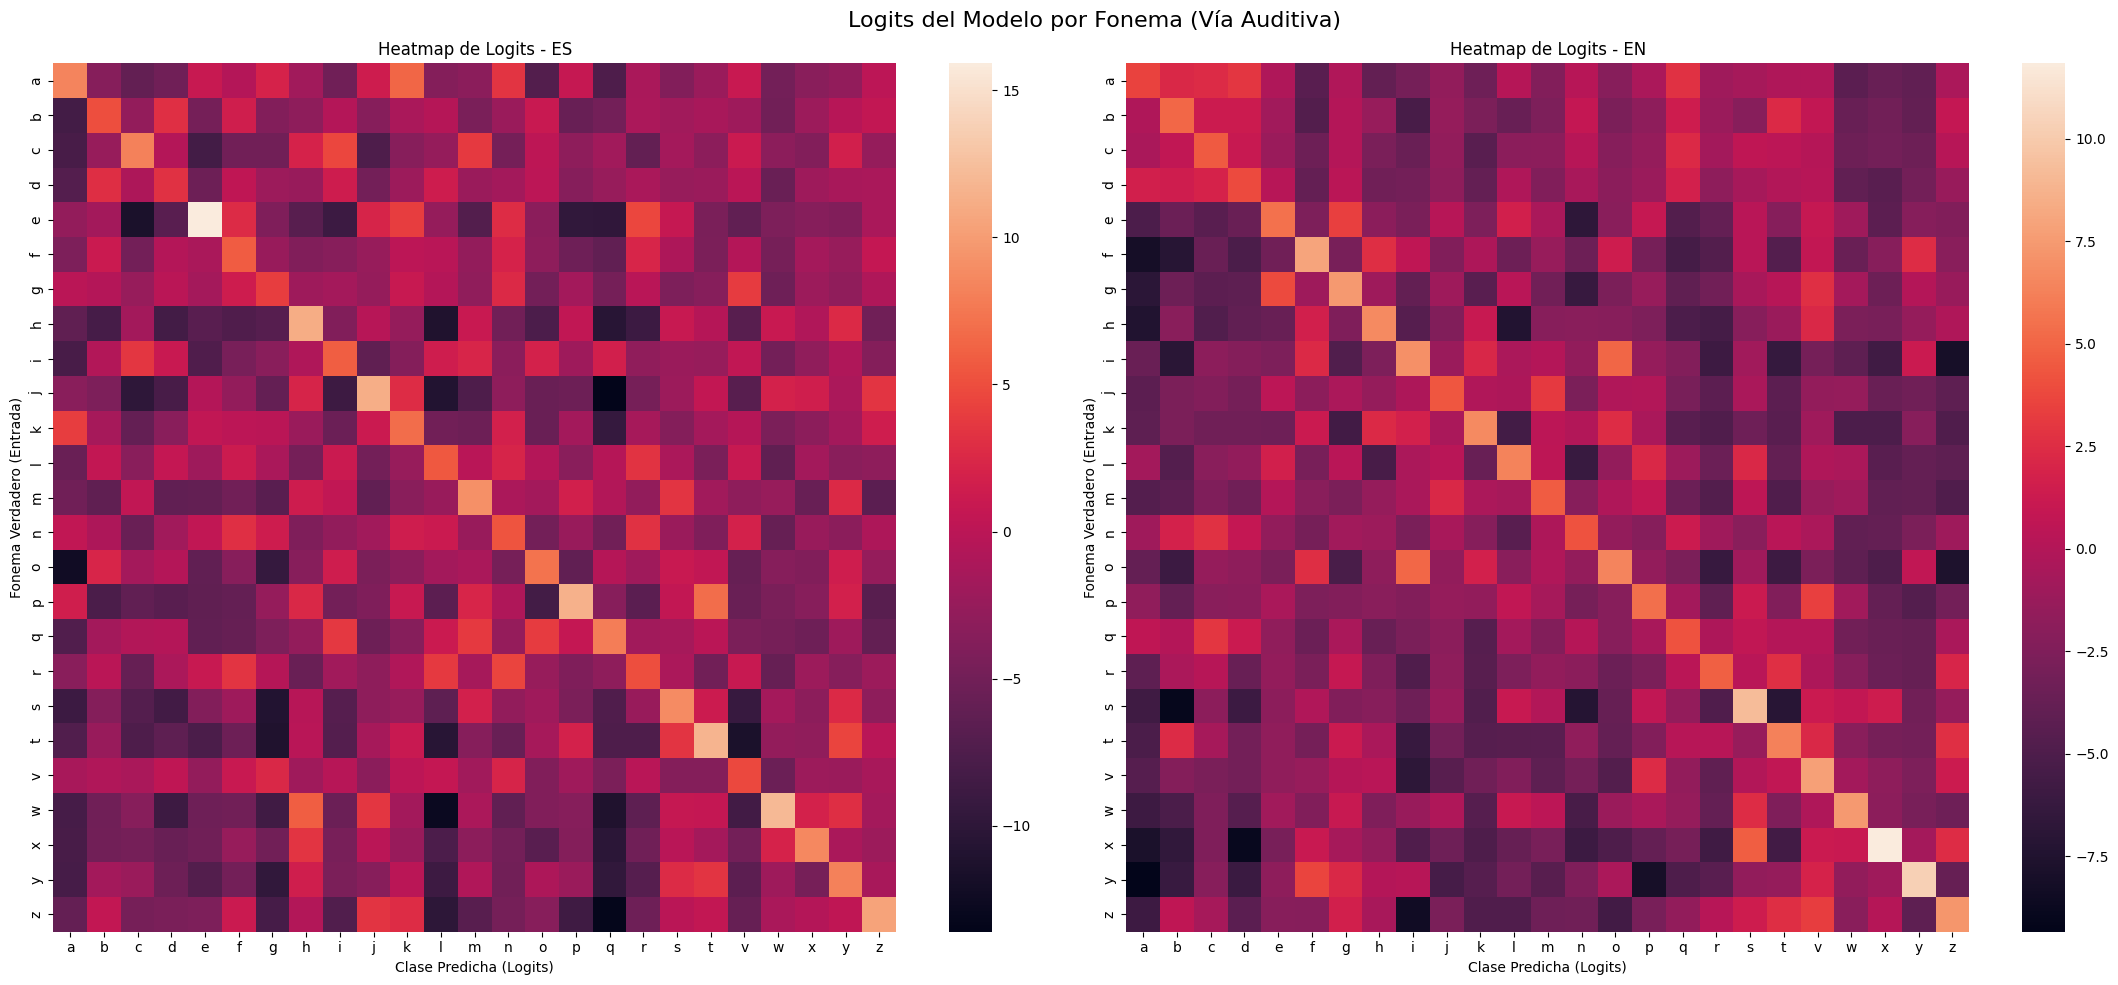

In [10]:
# --- 5.4 Heatmaps de Logits Comparativos ---
fig, axes = plt.subplots(1, len(LANGUAGES), figsize=(22, 10), sharey=False)
if len(LANGUAGES) == 1: axes = [axes]

for i, lang in enumerate(LANGUAGES):
    ax = axes[i]
    res = results_auditory[lang]
    
    # Crear un DataFrame con los logits y las etiquetas verdaderas (ordenadas)
    logits_df = pd.DataFrame(res['logits'], columns=res['labels'])
    logits_df = logits_df.sort_index(axis=1) # Ordenar columnas alfabéticamente
    
    # Como y_true ya está ordenado de 0 a N, el DataFrame de logits ya está en el orden correcto
    # (gracias al eval_loader no barajado).
    
    sns.heatmap(logits_df, xticklabels=True, yticklabels=res['labels'], ax=ax, cmap='rocket', annot=False)
    ax.set_title(f'Heatmap de Logits - {lang.upper()}')
    ax.set_xlabel('Clase Predicha (Logits)')
    ax.set_ylabel('Fonema Verdadero (Entrada)')

fig.suptitle('Logits del Modelo por Fonema (Vía Auditiva)', fontsize=16)
plt.tight_layout()
plt.savefig(figure_dir / f"comparative_{MODEL_ARCHITECTURE}_logits_heatmap.png")
plt.show()

## Paso 6: Guardado de Artefactos

Finalmente, guardamos los modelos entrenados y los informes de clasificación detallados en archivos para su uso futuro y documentación.

In [11]:
# --- Ignorar el UserWarning de scikit-learn para esta celda ---
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)

    for lang in LANGUAGES:
        # Guardar el modelo en disco
        model_path = model_dir / f"{lang}_{MODEL_ARCHITECTURE}.pth"
        torch.save(results_auditory[lang]['model'].state_dict(), model_path)
        print(f"Modelo para '{lang}' guardado en: {model_path}")
        
        # Guardar el informe de clasificación
        res = results_auditory[lang]
        report = classification_report(
            res['y_true'], res['y_pred'], 
            labels=range(len(res['labels'])),
            target_names=res['labels'],
            zero_division=0, 
            output_dict=True
        )
        report_df = pd.DataFrame(report).transpose()
        report_path = results_dir / f"{lang}_{MODEL_ARCHITECTURE}_classification_report.csv"
        report_df.to_csv(report_path)
        print(f"Informe de clasificación para '{lang}' guardado en: {report_path}\n")

print("--- Proceso del cuaderno 02 completado ---")

Modelo para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_auditory_cnn1d_comparative.pth
Informe de clasificación para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/tables/es_auditory_cnn1d_comparative_classification_report.csv

Modelo para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_auditory_cnn1d_comparative.pth
Informe de clasificación para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/tables/en_auditory_cnn1d_comparative_classification_report.csv

--- Proceso del cuaderno 02 completado ---
